In [43]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


In [37]:
# Load the training data
train_data = pd.read_csv('data.csv') 

# each row = one image, column 0 = label, columns 1 to 784 = pixels representing the image
print(f"shape of train data: {train_data.shape}")

x = train_data.iloc[:,1:] #pixel values
y = train_data.iloc[:,0] #labels

n = int(math.sqrt(x.shape[1]))
print(f"shape of images: {n} x {n}")


shape of train data: (42000, 785)
shape of images: 28 x 28


In [ ]:
# Prepare the data for training

x = pd.DataFrame(x) # transform x into a pandas DataFrame
x = x.apply(pd.to_numeric, errors='coerce').fillna(0) # Convert to numeric values only 
x = x.values / 255.0    # Normalize pixel values to [0, 1]
x = x.reshape(-1, 28,28, 1) # Reshape to (num_samples, 28, 28, 1 = grayscale) 

print(f"Shape of x after preparation: {x.shape}")

# Convert labels to categorical 
y = to_categorical(y, num_classes=10)
print(f"Shape of y after one-hot encoding:{y.shape}")

Shape of x after preparation: (42000, 28, 28, 1)
Shape of y after one-hot encoding:(42000, 10)


In [35]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"Shape of x_train: {x_train.shape}, y_train: {y_train.shape}")

Shape of x_train: (33600, 28, 28, 1), y_train: (33600, 10)


In [44]:
#Import the model and build the neural network

model = Sequential([          # Model definition
    Input(shape=(28, 28, 1)), # Defining the input : each image is 28x28 pixels with 1 channel (grayscale)
    Flatten(),                # Flatten the 2D image to a 1D vector
    Dense(128, activation='relu'), # First Hidden layer with 128 neurons and ReLU activation
    Dense(64, activation='relu'),  # Second Hidden layer with 64 neurons and ReLU activation
    Dense(10, activation='softmax')# Output layer with 10 neurons and softmax activation
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
# Adam to update weights + categorical_crossentropy to determine how close the predictions are to the true labels

# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/50
525/525 [==============================] - 5s 6ms/step - loss: 0.3600 - accuracy: 0.8976 - val_loss: 0.2053 - val_accuracy: 0.9392
Epoch 2/50
525/525 [==============================] - 2s 5ms/step - loss: 0.1485 - accuracy: 0.9565 - val_loss: 0.1383 - val_accuracy: 0.9605
Epoch 3/50
525/525 [==============================] - 3s 5ms/step - loss: 0.1006 - accuracy: 0.9706 - val_loss: 0.1335 - val_accuracy: 0.9606
Epoch 4/50
525/525 [==============================] - 3s 5ms/step - loss: 0.0737 - accuracy: 0.9774 - val_loss: 0.1148 - val_accuracy: 0.9643
Epoch 5/50
525/525 [==============================] - 3s 6ms/step - loss: 0.0574 - accuracy: 0.9816 - val_loss: 0.1011 - val_accuracy: 0.9694
Epoch 6/50
525/525 [==============================] - 3s 6ms/step - loss: 0.0430 - accuracy: 0.9867 - val_loss: 0.1069 - val_accuracy: 0.9680
Epoch 7/50
525/525 [==============================] - 3s 5ms/step - loss: 0.0350 - accuracy: 0.9889 - val_loss: 0.0992 - val_accuracy: 0.9718
Epoch 

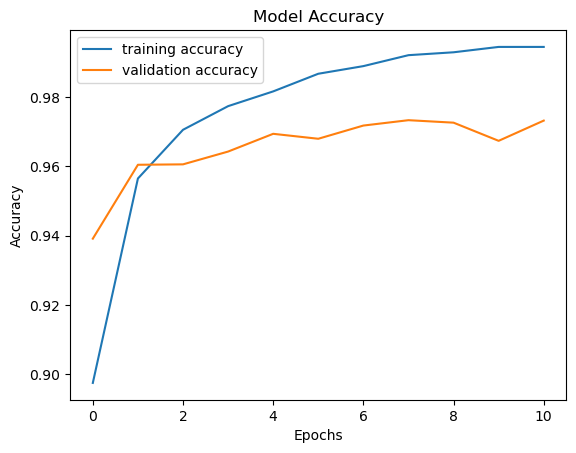

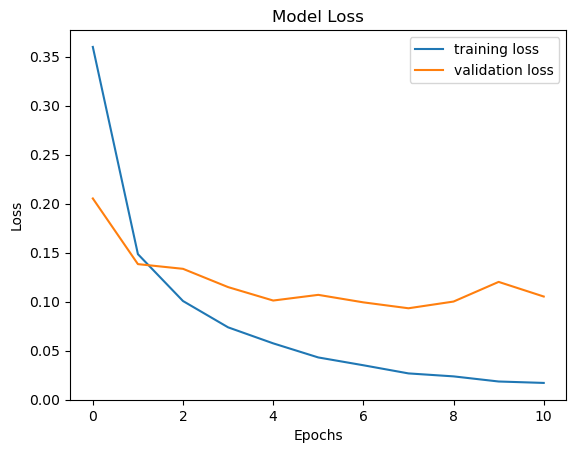

In [ ]:
# Display training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Diplay training loss and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [50]:
model.save('trained_model.h5')  # Save the trained model